In [2]:
# https://www.youtube.com/watch?v=q_HS4s1L8UI
# model is overfitted and not good for actual trading.

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn

data = pd.read_csv("C:/Users/trist/Downloads/AMZN.csv")



In [3]:
data = data[["Date", "Close"]]

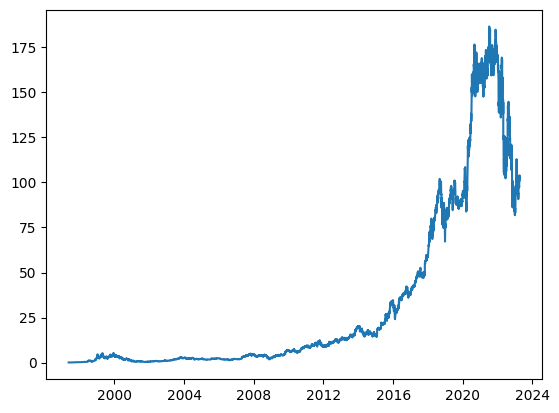

In [4]:
data['Date'] = pd.to_datetime(data["Date"])
plt.plot(data["Date"], data['Close'])

In [5]:
from copy import deepcopy as dc
def prepare_df(df, n_steps):
    df = dc(df)
    df.set_index('Date', inplace = True)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    
    df.dropna(inplace=True)

    return df

lookback = 5
shifted_df = prepare_df(data, lookback)
shifted_df.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5)
Date,,,,,,
1997-05-22,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-23,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [6]:
shifted_df_np = shifted_df.to_numpy()

In [7]:
# The MinMaxScaler from the sklearn.preprocessing module is commonly used in 
# machine learning to scale numerical features in a dataset to a specific range, 
# usually between 0 and 1. Scaling is an important preprocessing step in machine 
# learning because it can help improve the performance and convergence of many 
# algorithms.

from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_np = scaler.fit_transform(shifted_df_np)


In [8]:
X = shifted_df_np[:, 1:]
y = shifted_df_np[:, 0]

#flip column order for LSTM:

X = dc(np.flip(X, axis = 1))

X.shape, y.shape

((6511, 5), (6511,))

In [9]:
# 95% training, 5% test
split_index = int(len(X) * 0.95)
split_index

6185

In [10]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6185, 5), (326, 5), (6185,), (326,))

In [11]:
# LSTM needs an extra dimension

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6185, 5, 1), (326, 5, 1), (6185, 1), (326, 1))

In [12]:
#concert values into pytorch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6185, 5, 1]),
 torch.Size([326, 5, 1]),
 torch.Size([6185, 1]),
 torch.Size([326, 1]))

In [13]:
# we have to create a Dataset out of the Tensors

from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [14]:
train_dataset

In [15]:
#to get batches we need a DataLoader
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [16]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [23]:
#es folgt das Modell im Video 16:12 weitermachen
#input_size = number of features, here only one feature

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [24]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [25]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [26]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 1.029
Batch 200, Loss: 0.293
Batch 300, Loss: 0.037

Val Loss: 0.066
***************************************************

Epoch: 2
Batch 100, Loss: 0.015
Batch 200, Loss: 0.012
Batch 300, Loss: 0.009

Val Loss: 0.022
***************************************************

Epoch: 3
Batch 100, Loss: 0.006
Batch 200, Loss: 0.008
Batch 300, Loss: 0.006

Val Loss: 0.016
***************************************************

Epoch: 4
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004
Batch 300, Loss: 0.003

Val Loss: 0.012
***************************************************

Epoch: 5
Batch 100, Loss: 0.003
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.011
***************************************************

Epoch: 6
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.008
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.006
*****************

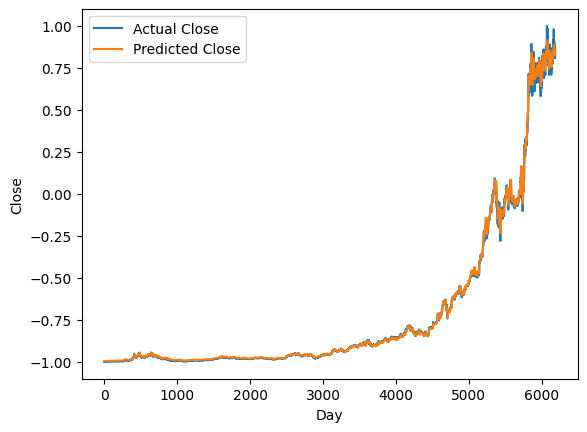

In [27]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [28]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([  0.60364159,   0.5986726 ,   0.59667166, ..., 171.60240922,
       170.67573154, 170.66106913])

In [30]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([6.97920000e-02, 7.49999904e-02, 7.91686060e-02, ...,
       1.69091508e+02, 1.73315004e+02, 1.68871004e+02])

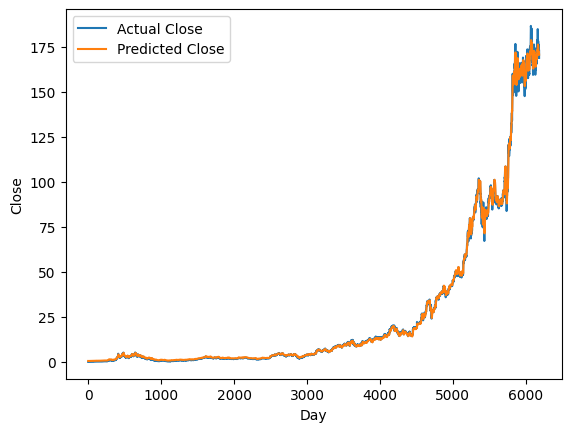

In [31]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [32]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])


In [33]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

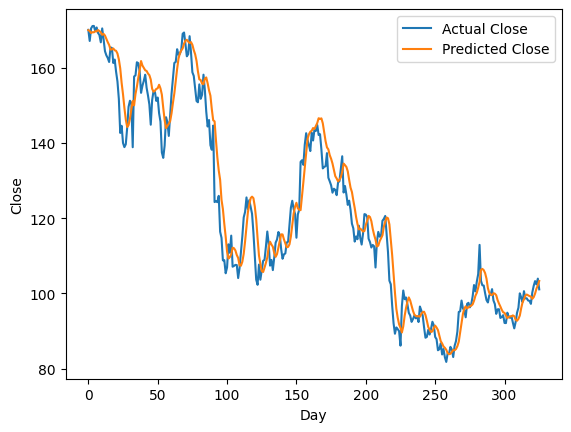

In [34]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
